# House Price Data

## Steps:
 - EDA 
 - Cleaning
 - Encoding
 - Modeling

Here, handle missing (some Iterative Imputer) and then encoding ordinals and using OneHot for nominals.

**Q:** would it be possible to use encode/OneHot first, and then IterativeImputer for all missing values?
- difficulty encoding missing values 
- might need to impute and then "unimpute" for IterativeImputer

In [403]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import time
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import scipy.stats 
from scipy.stats import boxcox
from scipy.special import boxcox1p
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression, LogisticRegression, HuberRegressor, BayesianRidge, Lasso, Ridge, ElasticNet, OrthogonalMatchingPursuit 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import utils
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostClassifier
# from lightgbm import LGBMRegressor
# import optuna

#### Load data

In [277]:
housePrice = pd.read_csv('Ames_HousePrice.csv', low_memory=False)

In [278]:
housePrice = housePrice.drop(columns=['Unnamed: 0','PID'])

#### Examine data

In [279]:
housePrice.shape

(2580, 80)

In [280]:
housePrice.head()

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,Lvl,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
2,1001,124900,30,C (all),60.0,6060,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
3,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,Lvl,...,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
4,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal


In [281]:
housePrice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2580 non-null   int64  
 1   SalePrice      2580 non-null   int64  
 2   MSSubClass     2580 non-null   int64  
 3   MSZoning       2580 non-null   object 
 4   LotFrontage    2118 non-null   float64
 5   LotArea        2580 non-null   int64  
 6   Street         2580 non-null   object 
 7   Alley          168 non-null    object 
 8   LotShape       2580 non-null   object 
 9   LandContour    2580 non-null   object 
 10  Utilities      2580 non-null   object 
 11  LotConfig      2580 non-null   object 
 12  LandSlope      2580 non-null   object 
 13  Neighborhood   2580 non-null   object 
 14  Condition1     2580 non-null   object 
 15  Condition2     2580 non-null   object 
 16  BldgType       2580 non-null   object 
 17  HouseStyle     2580 non-null   object 
 18  OverallQ

**Dictionary function to reference feature description**

In [282]:
with open('housePrice_features') as hp_feat:
    hp_dict = {}
    for line in hp_feat.readlines():
        feature, description = [*line.split(':')]
        hp_dict[feature] = description

In [283]:
hp_dict['LotFrontage']

' Linear feet of street connected to property\n'

In [284]:
# copy of raw data
housePrice_raw = housePrice.copy()

# Exploratory Data Analysis and Visualization

### Plotting and examining all features (categorical and numerical)

**Plotting function to examine data visually**

In [285]:
def feature_plot(df,col):
    sns.set_style('darkgrid')
    plt.figure(figsize = (32, 12))
    
    plt.subplot(1, 2, 1)
    
    order = df.groupby(by=[col])['SalePrice'].mean().sort_values().index
    
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        sns.distplot(df[col])
        plt.ylabel("Density", fontsize=30)
        plt.title("Density Plot of "+str(col),fontsize=30)
        plt.xticks(fontsize=30)
        
    else: #categorical variable 
        sns.countplot(x=col, data=df, order=order)
        plt.ylabel("Count", fontsize=30)
        
    plt.xlabel(col,fontsize=30)
    plt.xticks(rotation=90,fontsize=30)
    plt.yticks(fontsize=30)
    
    
    plt.subplot(1, 2, 2)
    
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        sns.regplot(x=col, y="SalePrice", data=df, scatter_kws={'alpha':0.3})
        plt.title("Sale Price vs "+str(col),fontsize=30)
    else:#categorical variable 
        sns.boxplot(x=col, y="SalePrice", data=df, order=order)
        
    plt.xlabel(col, fontsize=30)
    plt.ylabel("Sale Price", fontsize=30)
    plt.xticks(rotation=90,fontsize=30)
    plt.yticks(fontsize=30)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [286]:
for feature in housePrice:
    pass
#     if feature == 'SalePrice':
#         continue
#     feature_plot(housePrice, feature)

# Imputing Missing Values

In [287]:
# function for viewing columns with missing values
def nas(df):
    return df.loc[:, df.isna().sum() > 0 ].isna().sum().sort_values(ascending = False)

In [288]:
# investigate / impute column NaNs one by one
nas(housePrice)

PoolQC          2571
MiscFeature     2483
Alley           2412
Fence           2055
FireplaceQu     1241
LotFrontage      462
GarageCond       129
GarageQual       129
GarageFinish     129
GarageYrBlt      129
GarageType       127
BsmtExposure      71
BsmtFinType2      70
BsmtFinType1      69
BsmtQual          69
BsmtCond          69
MasVnrArea        14
MasVnrType        14
BsmtHalfBath       2
BsmtFullBath       2
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Electrical         1
dtype: int64

In [289]:
hp_dict['PoolQC']             
housePrice.PoolQC.unique()
housePrice.PoolQC = housePrice.PoolQC.fillna('none')
housePrice.groupby('PoolQC')['SalePrice'].agg(['mean', 'std', 'count'])

,mean,std,count
PoolQC,,,
Ex,465000.000000,212132.034356,2
Fa,215500.000000,48790.367902,2
Gd,215500.000000,62932.503526,2
TA,170500.000000,51529.117982,3
none,177786.980941,74571.704907,2571


In [290]:
hp_dict['MiscFeature']                                                           # drop
housePrice.groupby('MiscFeature')['SalePrice'].agg(['mean', 'std', 'count'])
housePrice = housePrice.drop('MiscFeature', axis = 1)

In [291]:
hp_dict['Alley']
# housePrice.Alley.unique()
housePrice.Alley.value_counts()
housePrice.Alley = housePrice.Alley.fillna('none')
housePrice.groupby('Alley')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
Alley,,,
Grvl,105,126345.990476,36101.160174
Pave,63,178559.698413,45650.146340
none,2412,180297.776949,76096.323125


In [292]:
hp_dict['Fence']  
# Good Privacy - GdPr
# Good Wood - GdWo
# Minimum Privacy - MnPr
# Minimum Wood - MnWw
housePrice.Fence = housePrice.Fence.fillna('none')
housePrice.groupby('Fence')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
Fence,,,
GdPrv,111,176726.576577,62331.695505
GdWo,103,144750.223301,47246.448542
MnPrv,301,146485.810631,44748.238487
MnWw,10,131965.000000,22333.856337
none,2055,184650.134307,78736.302160


In [293]:
hp_dict['FireplaceQu']
housePrice.FireplaceQu = housePrice.FireplaceQu.fillna('none')
housePrice.groupby('FireplaceQu')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
FireplaceQu,,,
Ex,35,340444.542857,112432.168836
Fa,70,168482.142857,36079.397184
Gd,619,223019.756058,91182.521787
Po,43,142528.674419,34116.467478
TA,572,204473.805944,63380.868389
none,1241,140650.717164,41618.136667


In [294]:
hp_dict['LotFrontage']                                 # impute using LotArea
housePrice.loc[housePrice.LotFrontage == 31]
housePrice.groupby('LotFrontage')['SalePrice'].agg(['count','mean','std'])
housePrice = housePrice.drop(columns='LotFrontage')

In [295]:
nas(housePrice)

GarageCond      129
GarageQual      129
GarageFinish    129
GarageYrBlt     129
GarageType      127
BsmtExposure     71
BsmtFinType2     70
BsmtQual         69
BsmtCond         69
BsmtFinType1     69
MasVnrType       14
MasVnrArea       14
BsmtFullBath      2
BsmtHalfBath      2
Electrical        1
BsmtUnfSF         1
BsmtFinSF2        1
GarageCars        1
GarageArea        1
BsmtFinSF1        1
TotalBsmtSF       1
dtype: int64

In [296]:
hp_dict['GarageCond']                                                       
housePrice.GarageCond = housePrice.GarageCond.fillna('none')
housePrice.groupby('GarageCond')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
GarageCond,,,
Ex,3,125000.000000,3905.124838
Fa,67,108543.791045,37994.751260
Gd,14,188278.571429,72267.145196
Po,11,106618.181818,27559.238675
TA,2356,184277.848048,74495.805841
none,129,106814.604651,33428.251290


In [297]:
hp_dict['GarageQual']                                             # should we try to compile garage? (is that clusters?)
housePrice.GarageQual = housePrice.GarageQual.fillna('none')              # compare relationship between rankings 
housePrice.groupby('GarageQual')['SalePrice'].agg(['count','mean','std'])           # across garage classifications

,count,mean,std
GarageQual,,,
Ex,3,241000.000000,202680.166765
Fa,110,118884.100000,39721.189121
Gd,22,242833.500000,119708.930561
Po,4,94350.000000,31556.140448
TA,2312,184297.039792,73708.905056
none,129,106814.604651,33428.251290


In [298]:
hp_dict['GarageFinish']                                             
housePrice.GarageFinish = housePrice.GarageFinish.fillna('none')
housePrice.groupby('GarageFinish')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
GarageFinish,,,
Fin,621,231925.247987,89751.688867
RFn,718,199724.565460,64714.442479
Unf,1112,142254.430755,44088.459471
none,129,106814.604651,33428.251290


In [299]:
hp_dict['GarageYrBlt']                                                         
housePrice.GarageYrBlt = housePrice.GarageYrBlt.fillna(0)
housePrice.groupby('GarageYrBlt')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
GarageYrBlt,,,
0.0,129,106814.604651,33428.251290
1895.0,1,89000.000000,NaN
1900.0,5,124760.000000,31569.494769
1906.0,1,135000.000000,NaN
1908.0,1,240000.000000,NaN
...,...,...,...
2006.0,67,263140.507463,82094.024392
2007.0,67,258978.552239,98539.246379
2008.0,44,292216.795455,87551.849537


In [300]:
hp_dict['GarageType']                                             
housePrice.GarageType = housePrice.GarageType.fillna('none')
housePrice.groupby('GarageType')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
GarageType,,,
2Types,21,154080.952381,36478.125213
Attchd,1527,200661.569090,75910.133901
Basment,27,155150.000000,33391.342153
BuiltIn,153,233054.464052,80768.842199
CarPort,9,110716.666667,27859.446333
Detchd,716,133291.765363,39764.381342
none,127,106048.622047,33116.655928


In [301]:
hp_dict['BsmtExposure']                                             
housePrice.BsmtExposure = housePrice.BsmtExposure.fillna('none')
housePrice.groupby('BsmtExposure')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtExposure,,,
Av,344,201482.340116,76537.790904
Gd,242,262873.061983,113165.344846
Mn,215,185463.330233,70096.651361
No,1708,163135.738876,57349.711224
none,71,112086.816901,42548.995226


In [302]:
hp_dict['BsmtFinType2']                                             
housePrice.BsmtFinType2 = housePrice.BsmtFinType2.fillna('none')
housePrice.groupby('BsmtFinType2')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtFinType2,,,
ALQ,53,188644.339623,82192.691433
BLQ,64,161466.140625,57560.260186
GLQ,32,211278.125000,101942.759031
LwQ,84,160725.297619,38958.990930
Rec,97,164338.402062,55684.315058
Unf,2180,181206.894954,76175.880106
none,70,111830.914286,44695.624964


In [303]:
hp_dict['BsmtFinType1']                                             
housePrice.BsmtFinType1 = housePrice.BsmtFinType1.fillna('none')
housePrice.groupby('BsmtFinType1')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtFinType1,,,
ALQ,397,163515.198992,48331.383704
BLQ,251,150852.749004,44819.815866
GLQ,753,231889.369190,87608.901286
LwQ,139,153106.834532,55352.198810
Rec,265,144782.030189,49548.992468
Unf,706,162617.998584,63191.379338
none,69,109335.710145,39810.106680


In [304]:
hp_dict['BsmtQual']                                            # does it matter if some basements (garages) don't have           
housePrice.BsmtQual = housePrice.BsmtQual.fillna('none')       # certain classifications, and are seen as 'none'
housePrice.groupby('BsmtQual')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtQual,,,
Ex,188,327308.005319,102928.298214
Fa,78,113467.051282,38699.187921
Gd,1077,200961.085422,56495.645593
Po,2,84950.000000,5727.564928
TA,1166,141389.656947,40290.731298
none,69,109335.710145,39810.106680


In [305]:
hp_dict['BsmtCond']                                             
housePrice.BsmtCond = housePrice.BsmtCond.fillna('none')
housePrice.groupby('BsmtCond')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtCond,,,
Ex,3,195000.000000,83216.584885
Fa,88,122382.875000,44683.700374
Gd,101,206709.128713,69427.407860
Po,3,95133.333333,34428.706530
TA,2316,181058.699914,74981.038735
none,69,109335.710145,39810.106680


In [306]:
hp_dict['MasVnrType']
housePrice.MasVnrType = housePrice.MasVnrType.fillna('None')
housePrice.groupby('MasVnrType')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
MasVnrType,,,
BrkCmn,20,145450.200000,43092.544242
BrkFace,804,208615.353234,82393.220408
None,1573,154854.005086,54413.116186
Stone,183,246845.519126,101989.391799


In [307]:
hp_dict['MasVnrArea']
housePrice['MasVnrArea'].fillna(0, inplace=True)

In [308]:
nas(housePrice)

BsmtFullBath    2
BsmtHalfBath    2
BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
Electrical      1
GarageCars      1
GarageArea      1
dtype: int64

In [309]:
hp_dict['BsmtHalfBath']
housePrice.BsmtHalfBath = housePrice.BsmtHalfBath.fillna(0)
housePrice.groupby('BsmtHalfBath')['SalePrice'].agg(['count','mean','std'])
# housePrice['BsmtHalfBath'].unique()

,count,mean,std
BsmtHalfBath,,,
0.0,2422,178732.360859,75413.038554
1.0,156,167413.782051,68265.360217
2.0,2,193750.000000,93691.648507


In [310]:
hp_dict['BsmtFullBath']
housePrice.BsmtFullBath = housePrice.BsmtHalfBath.fillna(0)
housePrice.groupby('BsmtFullBath')['SalePrice'].agg(['count','mean','std'])
# housePrice['BsmtHalfBath'].unique()

,count,mean,std
BsmtFullBath,,,
0.0,2422,178732.360859,75413.038554
1.0,156,167413.782051,68265.360217
2.0,2,193750.000000,93691.648507


In [311]:
hp_dict['BsmtFinSF1']
housePrice.BsmtFinSF1 = housePrice.BsmtFinSF1.fillna(housePrice.BsmtFinSF1.mean())
housePrice.groupby('BsmtFinSF1')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtFinSF1,,,
0.0,774,157976.060724,63277.881933
2.0,1,214000.000000,NaN
16.0,12,195682.500000,54076.192396
20.0,7,184600.000000,39983.788381
24.0,22,202248.136364,25915.452934
...,...,...,...
2158.0,1,468000.000000,NaN
2188.0,1,611657.000000,NaN
2257.0,1,615000.000000,NaN


In [312]:
hp_dict['BsmtFinSF2']
housePrice.BsmtFinSF2 = housePrice.BsmtFinSF2.fillna(housePrice.BsmtFinSF2.mean())
housePrice.groupby('BsmtFinSF2')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtFinSF2,,,
0.0,2248,179064.810943,76314.061051
6.0,1,142500.000000,NaN
12.0,1,134000.000000,NaN
32.0,1,200000.000000,NaN
35.0,1,143250.000000,NaN
...,...,...,...
1127.0,1,213250.000000,NaN
1164.0,1,182000.000000,NaN
1393.0,1,584500.000000,NaN


In [313]:
hp_dict['BsmtUnfSF']
housePrice.BsmtUnfSF = housePrice.BsmtUnfSF.fillna(housePrice.BsmtUnfSF.mean())
housePrice.groupby('BsmtUnfSF')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtUnfSF,,,
0.0,216,143208.25,56797.218229
14.0,1,151000.00,NaN
15.0,1,223500.00,NaN
17.0,1,245000.00,NaN
20.0,1,119900.00,NaN
...,...,...,...
2042.0,1,253293.00,NaN
2046.0,1,372500.00,NaN
2062.0,1,270000.00,NaN


In [314]:
hp_dict['TotalBsmtSF']
housePrice.TotalBsmtSF = housePrice.TotalBsmtSF.fillna(housePrice.TotalBsmtSF.mean())
housePrice.groupby('TotalBsmtSF')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
TotalBsmtSF,,,
0.0,68,109781.823529,39931.965258
105.0,1,116000.000000,NaN
160.0,1,113500.000000,NaN
173.0,1,89000.000000,NaN
190.0,1,91300.000000,NaN
...,...,...,...
2846.0,1,500000.000000,NaN
3094.0,1,555000.000000,NaN
3138.0,1,184750.000000,NaN


In [315]:
nas(housePrice)

Electrical    1
GarageCars    1
GarageArea    1
dtype: int64

In [316]:
hp_dict['Electrical']
housePrice.groupby('Electrical')['SalePrice'].agg(['count','mean','std'])
housePrice['Electrical'] = housePrice['Electrical'].fillna(housePrice.Electrical.mode())

In [317]:
hp_dict['GarageCars']
housePrice.groupby('GarageCars')['SalePrice'].agg(['count','mean','std'])
housePrice['GarageCars'] = housePrice['GarageCars'].fillna(housePrice.GarageCars.median())

In [318]:
hp_dict['GarageArea']
housePrice.groupby('GarageArea')['SalePrice'].agg(['count','mean','std'])
housePrice['GarageArea'] = housePrice['GarageArea'].fillna(housePrice.GarageArea.median())

In [319]:
nas(housePrice)

Electrical    1
dtype: int64

In [320]:
housePrice.to_csv('HousePrice_Clean.csv', index = False)

#### Date Columns

In [321]:
# DATES - dtypes        ### thoughts about combining columns / datetime?

date_ = housePrice.filter(regex='Yr|Mo|Date')
date_.isna().sum()

housePrice['GarageYrBlt'].dtypes                       
housePrice['GarageYrBlt'].astype('int')
# pd.to_datetime(housePrice.GarageYrBlt, format = '%Y')

0       1939
1       1984
2       1930
3       1940
4       2001
        ... 
2575    1916
2576    1955
2577    1949
2578    2000
2579    1993
Name: GarageYrBlt, Length: 2580, dtype: int32

# Encoding ordinals and One Hot Encoding for nominals

In [322]:
housePrice = pd.read_csv('HousePrice_Clean.csv')

# copy of data without encoding
housePrice_cat = housePrice.copy()

In [323]:
hp_num = housePrice.select_dtypes(include = [np.number])
hp_cat = housePrice.select_dtypes(exclude = [np.number])
hp_cat_ord = []
hp_cat_nom = []
dropped = []

In [324]:
# how many numeric and categorical values
print("numeric", hp_num.shape[1])
print("categorical", hp_cat.shape[1])

numeric 36
categorical 42


In [325]:
housePrice.groupby('MSZoning')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('MSZoning')
len(hp_cat_nom)

1

In [326]:
housePrice.groupby('Street')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Street')
hp_cat_nom

['MSZoning', 'Street']

In [327]:
housePrice.groupby('Alley')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Alley')
hp_cat_nom

['MSZoning', 'Street', 'Alley']

In [328]:
housePrice.groupby('LotShape')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('LotShape')
hp_cat_nom

['MSZoning', 'Street', 'Alley', 'LotShape']

In [329]:
housePrice.groupby('LandContour')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('LandContour')
hp_cat_nom

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour']

In [330]:
housePrice.groupby('Utilities')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Utilities')
hp_cat_nom

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities']

In [331]:
housePrice.groupby('LotConfig')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('LotConfig')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig']

In [332]:
housePrice.groupby('LandSlope')['SalePrice'].agg(['count','mean','std'])  # ordinal --> create scale map dict 
hp_cat_ord.append('LandSlope')
scale = {"Gtl":1, "Mod":2, "Sev":3}
housePrice['LandSlope_Enc'] = housePrice['LandSlope'].replace(scale)
housePrice = housePrice.drop(columns='LandSlope')
hp_cat_ord

['LandSlope']

In [333]:
housePrice.groupby('Neighborhood')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Neighborhood')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood']

In [334]:
housePrice.groupby('Condition1')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Condition1')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1']

In [335]:
housePrice.groupby('Condition2')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Condition2')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2']

In [336]:
housePrice.groupby('BldgType')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('BldgType')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType']

In [337]:
housePrice.groupby('HouseStyle')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('HouseStyle')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle']

In [338]:
housePrice.groupby('RoofStyle')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('RoofStyle')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle']

In [339]:
housePrice.groupby('RoofMatl')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('RoofMatl')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl']

In [340]:
housePrice.groupby('Exterior1st')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Exterior1st')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st']

In [341]:
housePrice.groupby('Exterior2nd')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Exterior2nd')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd']

In [342]:
housePrice.groupby('MasVnrType')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('MasVnrType')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType']

In [343]:
housePrice.groupby('ExterQual')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('ExterQual')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['ExterQual_Enc'] = housePrice['ExterQual'].replace(scale)
housePrice = housePrice.drop(columns='ExterQual')
hp_cat_ord

['LandSlope', 'ExterQual']

In [344]:
housePrice.groupby('ExterCond')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('ExterCond')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['ExterCond_Enc'] = housePrice['ExterCond'].replace(scale)
housePrice = housePrice.drop(columns='ExterCond')
hp_cat_ord

['LandSlope', 'ExterQual', 'ExterCond']

In [345]:
housePrice.groupby('Foundation')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Foundation')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation']

In [346]:
housePrice.groupby('BsmtQual')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('BsmtQual')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['BsmtQual_Enc'] = housePrice['BsmtQual'].replace(scale)
housePrice = housePrice.drop(columns='BsmtQual')
hp_cat_ord

['LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual']

In [347]:
housePrice.groupby('BsmtCond')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('BsmtCond')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['BsmtCond_Enc'] = housePrice['BsmtCond'].replace(scale)
housePrice = housePrice.drop(columns='BsmtCond')
hp_cat_ord

['LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond']

In [348]:
housePrice.groupby('BsmtExposure')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('BsmtExposure')
scale = {"none":0, "No":1, "Mn": 2, "Av":3, "Gd":4, "Ex":5}
housePrice['BsmtExposure_Enc'] = housePrice['BsmtExposure'].replace(scale)
housePrice = housePrice.drop(columns='BsmtExposure')
len(hp_cat_ord)

6

In [349]:
housePrice.groupby('BsmtFinType1')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('BsmtFinType1')
scale = {"none":0, "Unf":1, "LwQ": 2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6}
housePrice['BsmtFinType1_Enc'] = housePrice['BsmtFinType1'].replace(scale)
housePrice = housePrice.drop(columns='BsmtFinType1')
len(hp_cat_ord)

7

In [350]:
housePrice.groupby('BsmtFinType2')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('BsmtFinType2')
scale = {"none":0, "Unf":1, "LwQ": 2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6}
housePrice['BsmtFinType2_Enc'] = housePrice['BsmtFinType2'].replace(scale)
housePrice = housePrice.drop(columns='BsmtFinType2')
hp_cat_ord

['LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2']

In [351]:
housePrice.groupby('Heating')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Heating')
len(hp_cat_nom)

19

In [352]:
housePrice.groupby('HeatingQC')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('HeatingQC')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['HeatingQC_Enc'] = housePrice['HeatingQC'].replace(scale)
housePrice = housePrice.drop(columns='HeatingQC')
hp_cat_ord

['LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC']

In [353]:
housePrice.groupby('CentralAir')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('CentralAir')
len(hp_cat_nom)

20

In [354]:
housePrice.groupby('Electrical')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Electrical')
len(hp_cat_nom)

21

In [355]:
housePrice.groupby('KitchenQual')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('KitchenQual')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['KitchenQual_Enc'] = housePrice['KitchenQual'].replace(scale)
housePrice = housePrice.drop(columns='KitchenQual')
hp_cat_ord

['LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual']

In [356]:
housePrice.groupby('Functional')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('Functional')
scale = {"Typ":0, "Min1":1, "Min2": 2, "Mod":3, "Maj1":4, "Maj2":5, "Sal":6}
housePrice['Functional_Enc'] = housePrice['Functional'].replace(scale)
housePrice = housePrice.drop(columns='Functional')
hp_cat_ord

['LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual',
 'Functional']

In [357]:
housePrice.groupby('FireplaceQu')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('FireplaceQu')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['FireplaceQu_Enc'] = housePrice['FireplaceQu'].replace(scale)
housePrice = housePrice.drop(columns='FireplaceQu')
hp_cat_ord

['LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual',
 'Functional',
 'FireplaceQu']

In [358]:
housePrice.groupby('GarageType')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('GarageType')
len(hp_cat_nom)

22

In [359]:
housePrice.groupby('GarageFinish')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('GarageFinish')
scale = {"none":0, "Unf":1, "RFn": 2, "Fin":3}
housePrice['GarageFinish_Enc'] = housePrice['GarageFinish'].replace(scale)
housePrice = housePrice.drop(columns='GarageFinish')
len(hp_cat_ord)

13

In [360]:
housePrice.groupby('GarageQual')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('GarageQual')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['GarageQual_Enc'] = housePrice['GarageQual'].replace(scale)
housePrice = housePrice.drop(columns='GarageQual')
len(hp_cat_ord)

14

In [361]:
housePrice.groupby('GarageCond')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('GarageCond')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['GarageCond_Enc'] = housePrice['GarageCond'].replace(scale)
housePrice = housePrice.drop(columns='GarageCond')
len(hp_cat_ord)

15

In [362]:
housePrice.groupby('PavedDrive')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('PavedDrive')
scale = {"N":0, "P":1, "Y": 2}
housePrice['PavedDrive_Enc'] = housePrice['PavedDrive'].replace(scale)
housePrice = housePrice.drop(columns='PavedDrive')
len(hp_cat_ord)

16

In [363]:
housePrice.groupby('PoolQC')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('PoolQC')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['PoolQC_Enc'] = housePrice['PoolQC'].replace(scale)
housePrice = housePrice.drop(columns='PoolQC')
len(hp_cat_ord)

17

In [364]:
housePrice.groupby('Fence')['SalePrice'].agg(['count','mean','std'])   ### measuring two completely different things
dropped.append('Fence')
housePrice = housePrice.drop(columns='Fence')                                           ## DROP

In [365]:
housePrice.groupby('SaleType')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('SaleType')
len(hp_cat_nom)

23

In [366]:
housePrice.groupby('SaleCondition')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('SaleCondition')
len(hp_cat_nom)

24

In [367]:
# see if ordinal/nominal add up
print("ordinal", len(hp_cat_ord))
print("nominal", len(hp_cat_nom))
print("categorical total", hp_cat.shape[1])

ordinal 17
nominal 24
categorical total 42


In [368]:
hp_cat.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType',
       'SaleCondition'],
      dtype='object')

## Correlation (before OneHot Encoding)

### Assessing for Multicollinearity

,GrLivArea,SalePrice,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,BsmtFinType2_Enc,HeatingQC_Enc,KitchenQual_Enc,Functional_Enc,FireplaceQu_Enc,GarageFinish_Enc,GarageQual_Enc,GarageCond_Enc,PavedDrive_Enc,PoolQC_Enc
GrLivArea,1.000000,0.719981,0.070785,0.260322,0.559897,-0.105670,0.228400,0.306035,0.385898,0.164852,...,-0.037962,0.262223,0.384736,0.077225,0.365403,0.348129,0.027058,0.015629,0.125275,0.074332
SalePrice,0.719981,1.000000,-0.084587,0.274443,0.790501,-0.101091,0.544370,0.514309,0.498432,0.460636,...,0.025494,0.396706,0.588980,-0.103462,0.458405,0.533627,0.008012,-0.012181,0.268327,0.087288
MSSubClass,0.070785,-0.084587,1.000000,-0.198040,0.056468,-0.075542,0.053852,0.056756,0.018243,-0.074081,...,-0.035436,-0.014753,-0.005057,0.012495,-0.067130,-0.018207,-0.062426,-0.058419,-0.017050,-0.017598
LotArea,0.260322,0.274443,-0.198040,1.000000,0.080607,-0.032693,0.012397,0.010293,0.103514,0.163460,...,0.055343,0.001002,0.044683,0.077334,0.147225,0.107698,0.015401,0.013619,-0.007465,0.032242
OverallQual,0.559897,0.790501,0.056468,0.080607,1.000000,-0.095927,0.574400,0.546297,0.401996,0.273800,...,-0.001032,0.397544,0.596783,-0.170620,0.399744,0.524713,-0.005057,-0.020462,0.288091,0.043693
OverallCond,-0.105670,-0.101091,-0.075542,-0.032693,-0.095927,1.000000,-0.397274,0.065100,-0.142250,-0.064328,...,0.081021,-0.022693,-0.063993,-0.106980,-0.045408,-0.195723,0.080899,-0.008236,-0.052298,-0.021996
YearBuilt,0.228400,0.544370,0.053852,0.012397,0.574400,-0.397274,1.000000,0.572276,0.302447,0.303577,...,0.005035,0.353059,0.475910,-0.160484,0.151080,0.579106,-0.166146,-0.086983,0.464789,0.019385
YearRemodAdd,0.306035,0.514309,0.056756,0.010293,0.546297,0.065100,0.572276,1.000000,0.171725,0.156444,...,-0.013389,0.480558,0.591742,-0.079975,0.164248,0.414106,-0.068760,-0.066300,0.191084,0.000825
MasVnrArea,0.385898,0.498432,0.018243,0.103514,0.401996,-0.142250,0.302447,0.171725,1.000000,0.275866,...,-0.006113,0.138530,0.243105,-0.076441,0.228658,0.257828,-0.035162,-0.005532,0.159312,0.023931
BsmtFinSF1,0.164852,0.460636,-0.074081,0.163460,0.273800,-0.064328,0.303577,0.156444,0.275866,1.000000,...,-0.010687,0.070259,0.181450,-0.066697,0.176789,0.271445,-0.047864,-0.024062,0.226451,0.047171


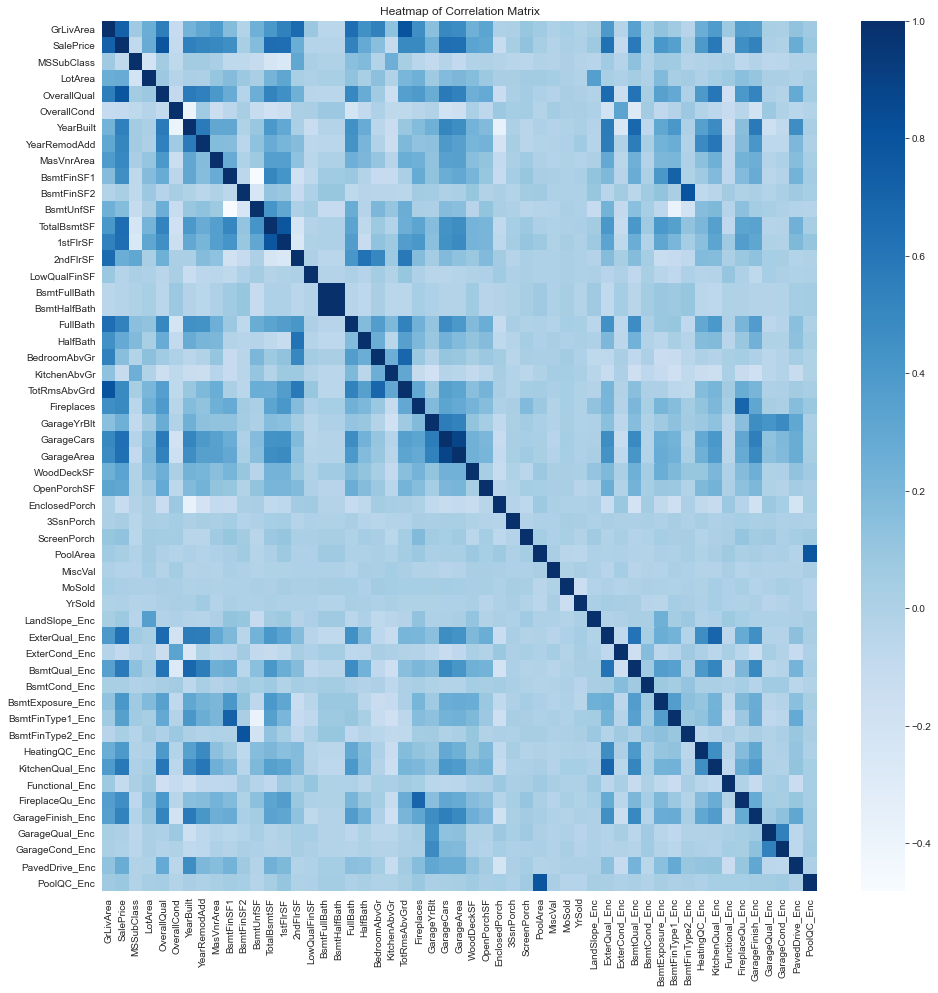

In [369]:
corr=housePrice.corr()
plt.figure(figsize = (16, 16))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap ="Blues")
plt.title('Heatmap of Correlation Matrix')
corr

In [370]:
high_corr_pairs = np.where(abs(corr) > 0.7)
high_corr_pairs = [(corr.index[x], corr.columns[y]) 
                   for x, y in  zip(*high_corr_pairs)
                   if x != y and x < y]

In [371]:
high_corr_pairs

[('GrLivArea', 'SalePrice'),
 ('GrLivArea', 'TotRmsAbvGrd'),
 ('SalePrice', 'OverallQual'),
 ('BsmtFinSF1', 'BsmtFinType1_Enc'),
 ('BsmtFinSF2', 'BsmtFinType2_Enc'),
 ('TotalBsmtSF', '1stFlrSF'),
 ('BsmtFullBath', 'BsmtHalfBath'),
 ('GarageCars', 'GarageArea'),
 ('PoolArea', 'PoolQC_Enc')]

### High Correlation with SalePrice

In [372]:
top_corr_features = housePrice.corrwith(housePrice['SalePrice']).sort_values(ascending=False)
top_corr_features.where(top_corr_features > .6, inplace=True)
top_corr_features.dropna(inplace=True)
top_corr_features

SalePrice        1.000000
OverallQual      0.790501
GrLivArea        0.719981
TotalBsmtSF      0.652002
1stFlrSF         0.642613
GarageCars       0.638722
GarageArea       0.634971
ExterQual_Enc    0.626728
dtype: float64

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


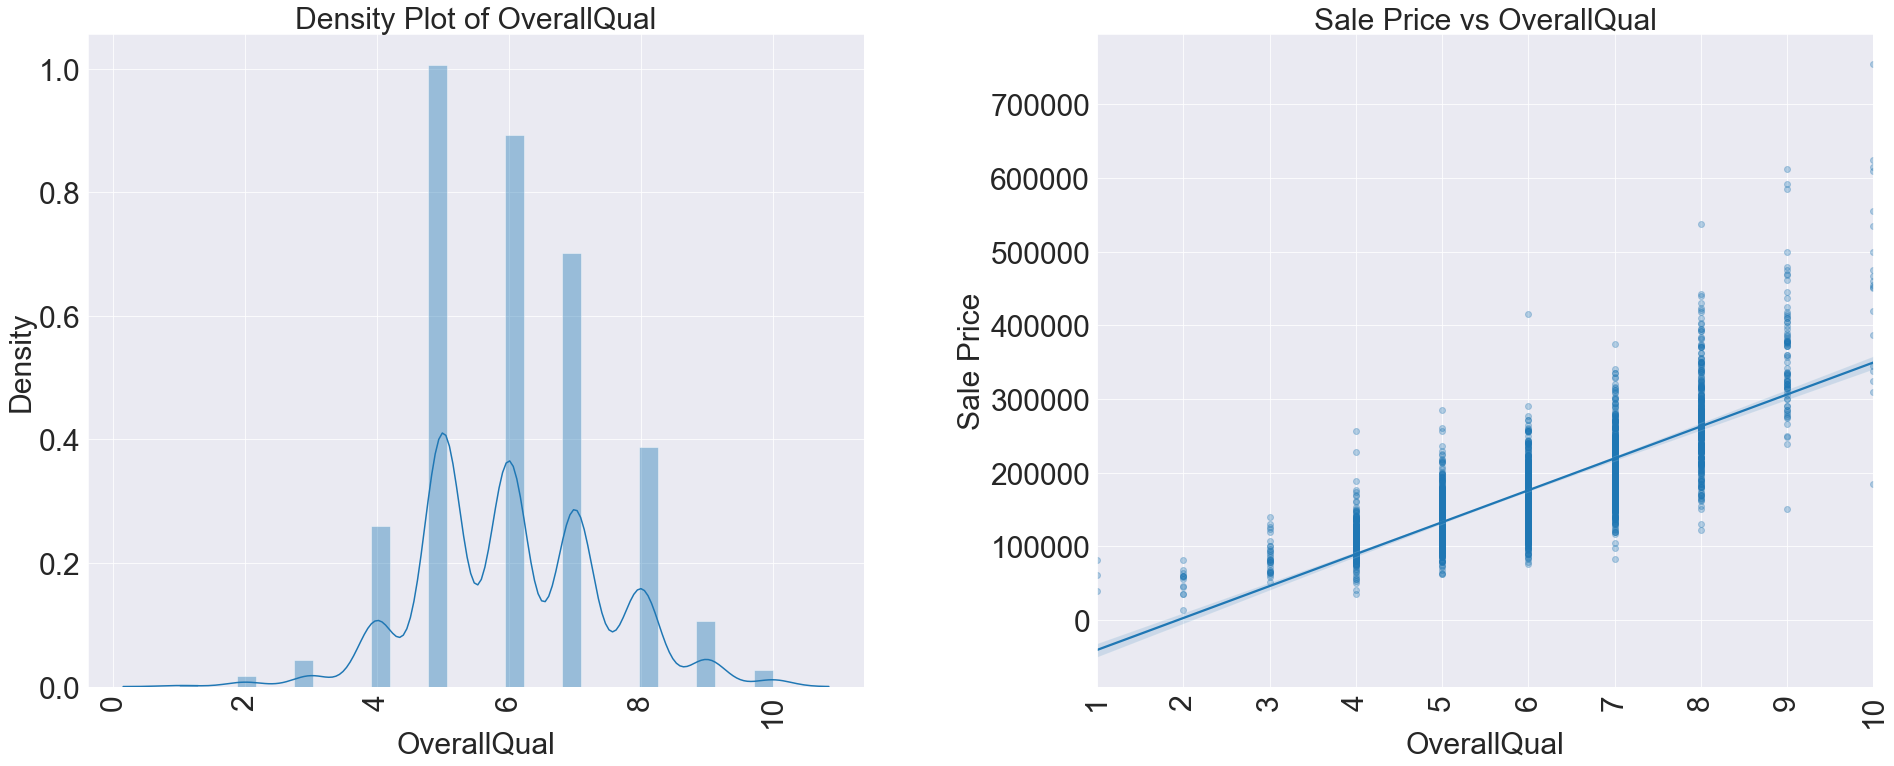

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


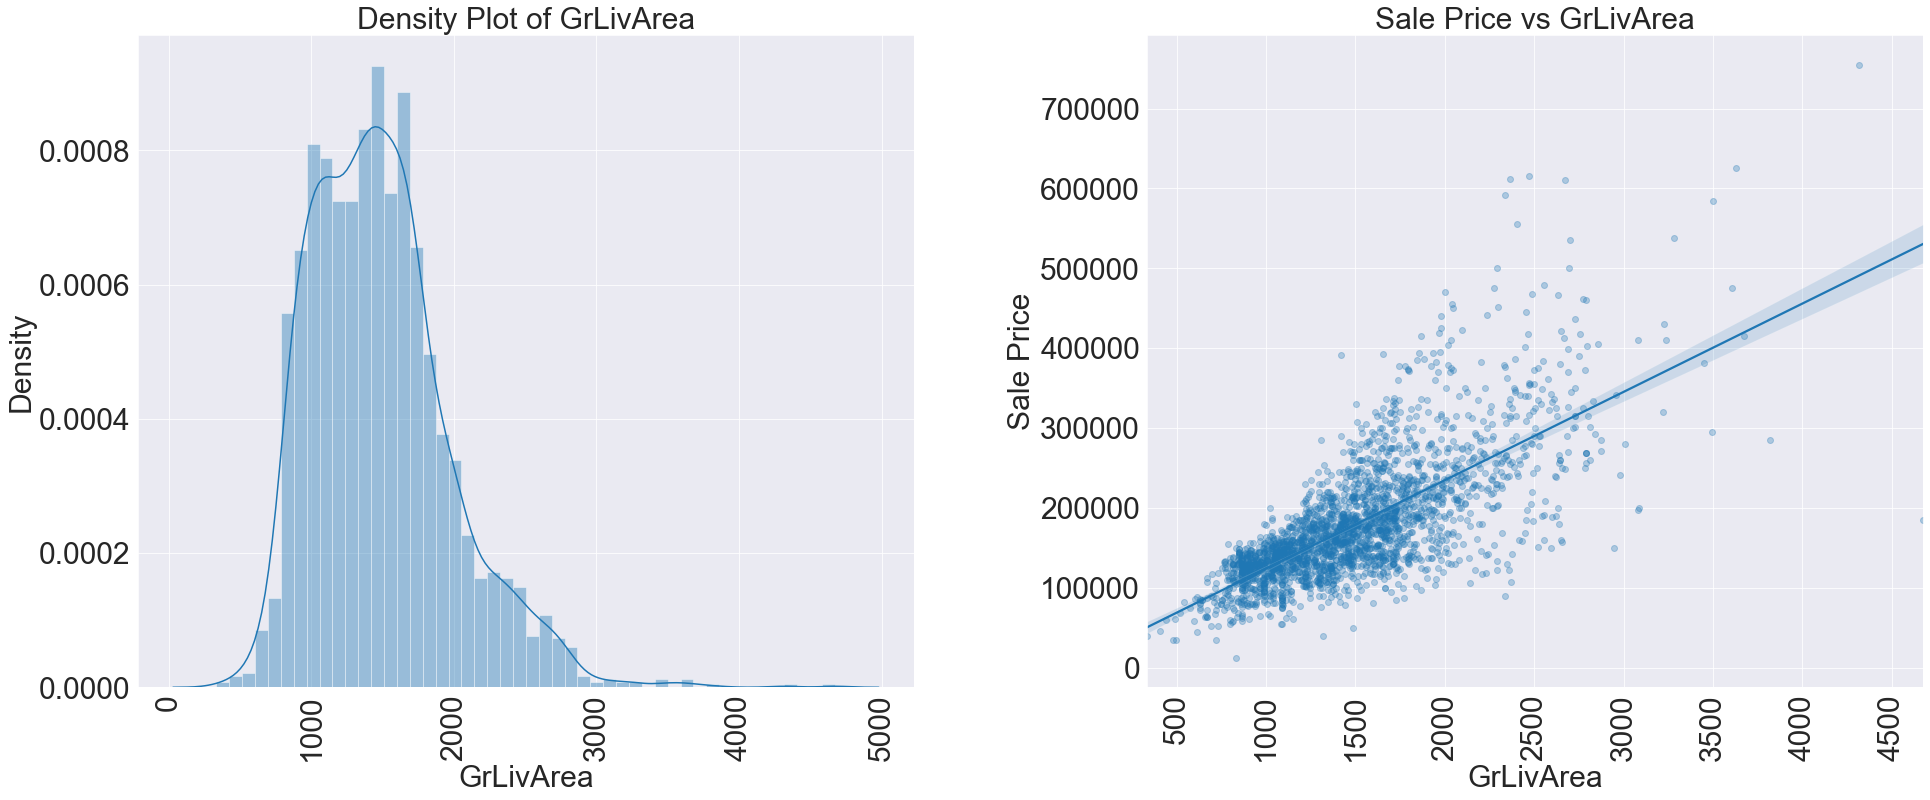

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


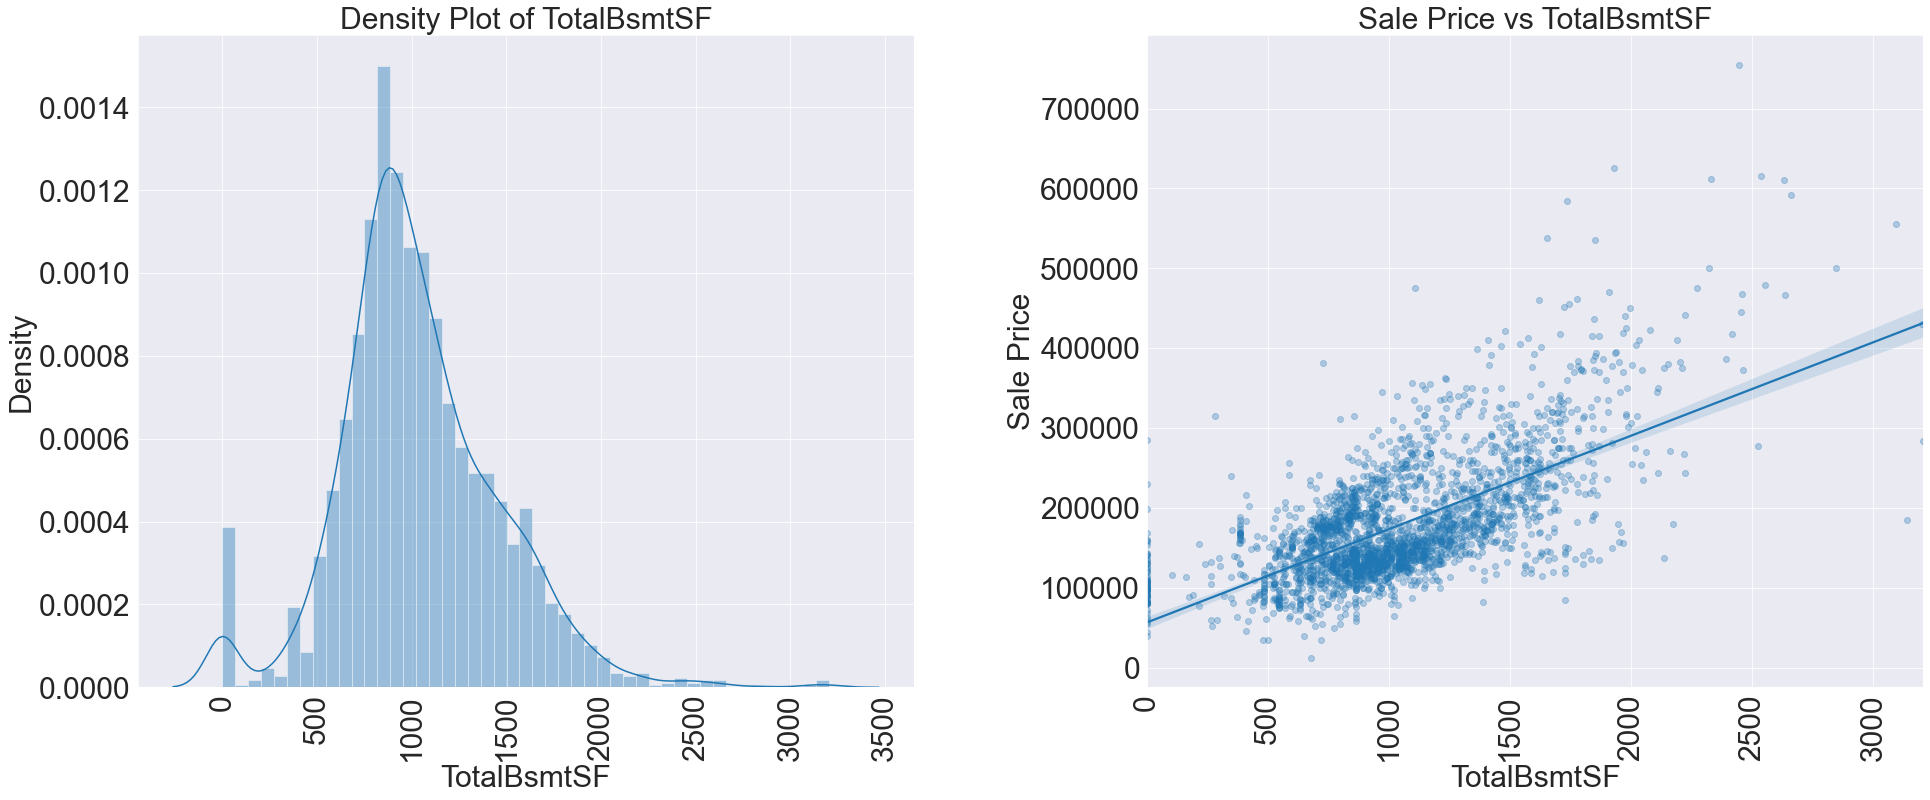

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


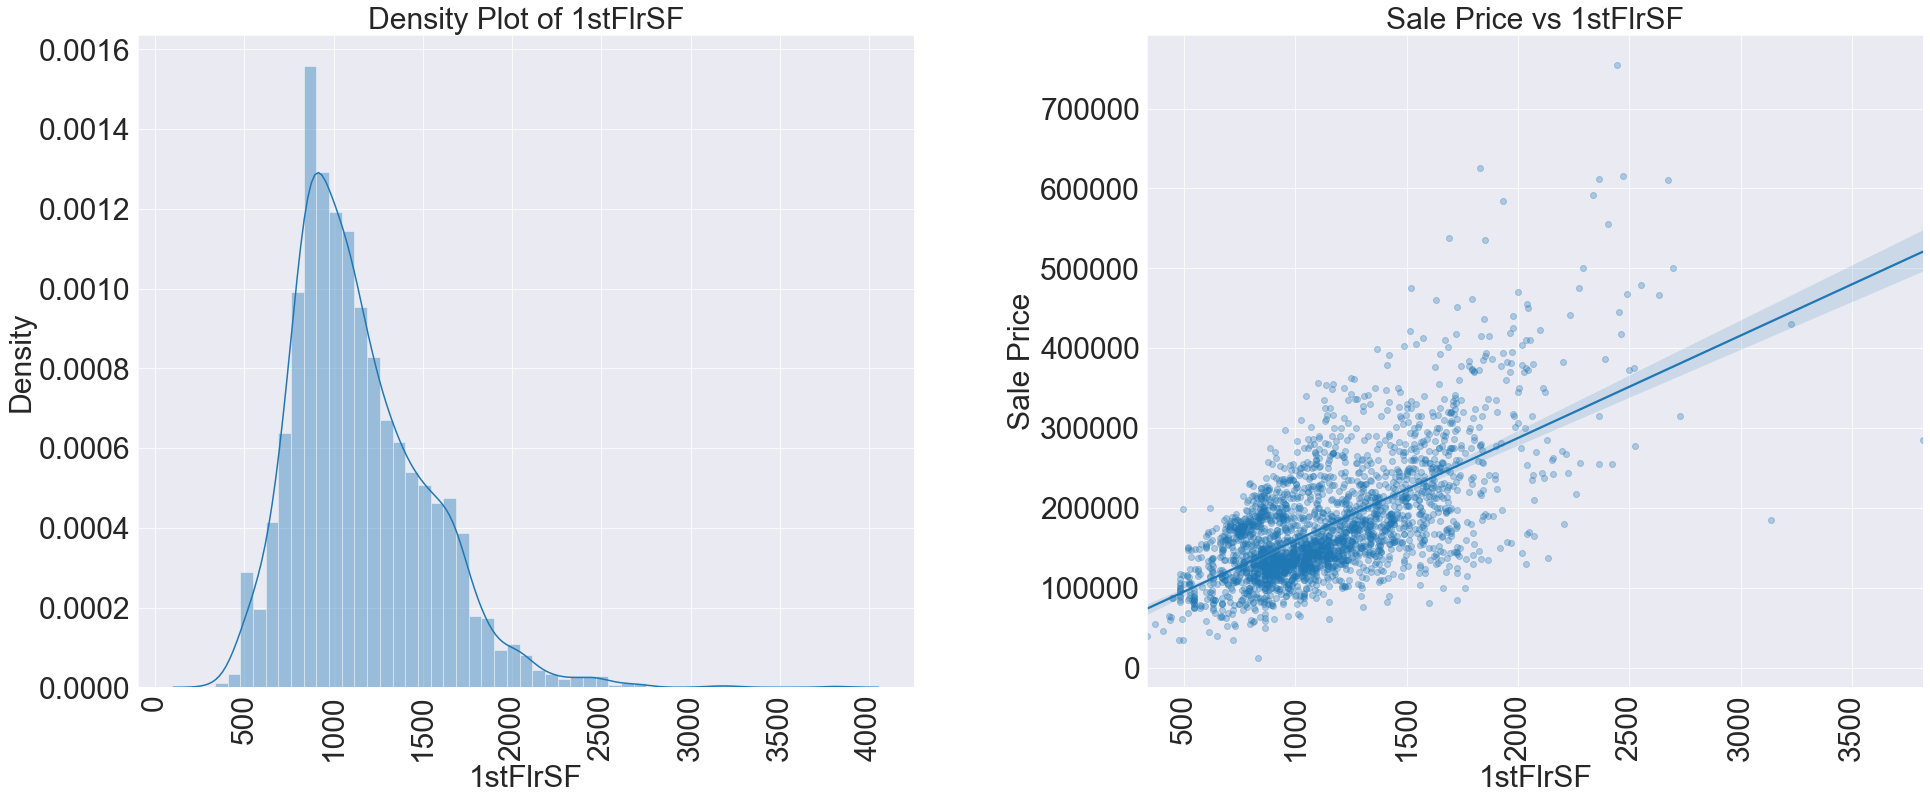

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


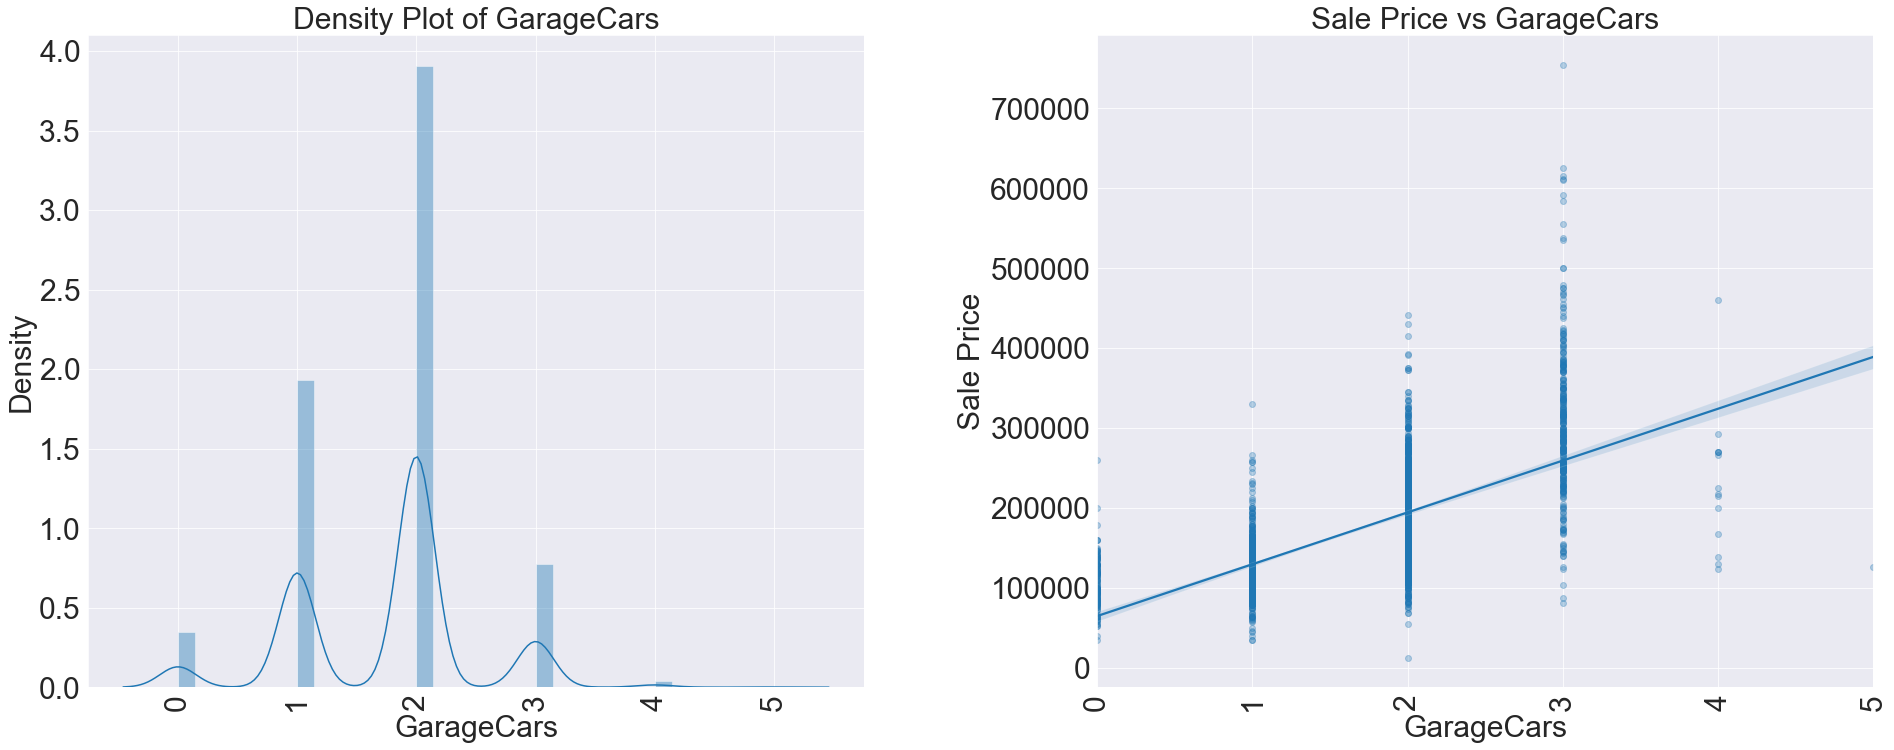

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


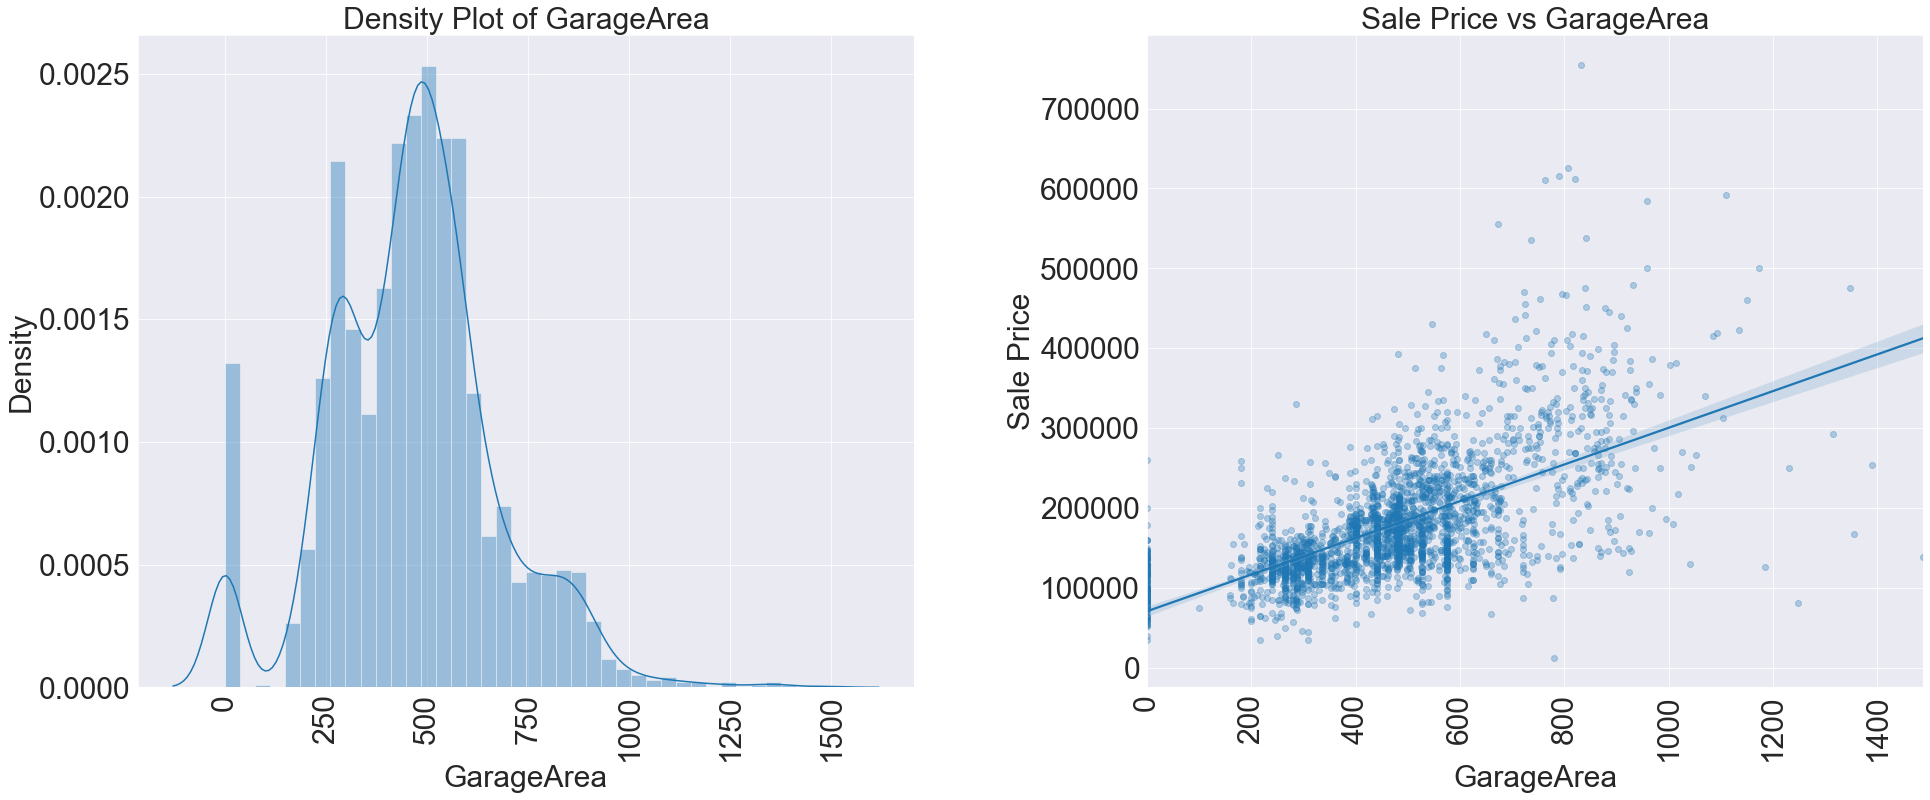

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


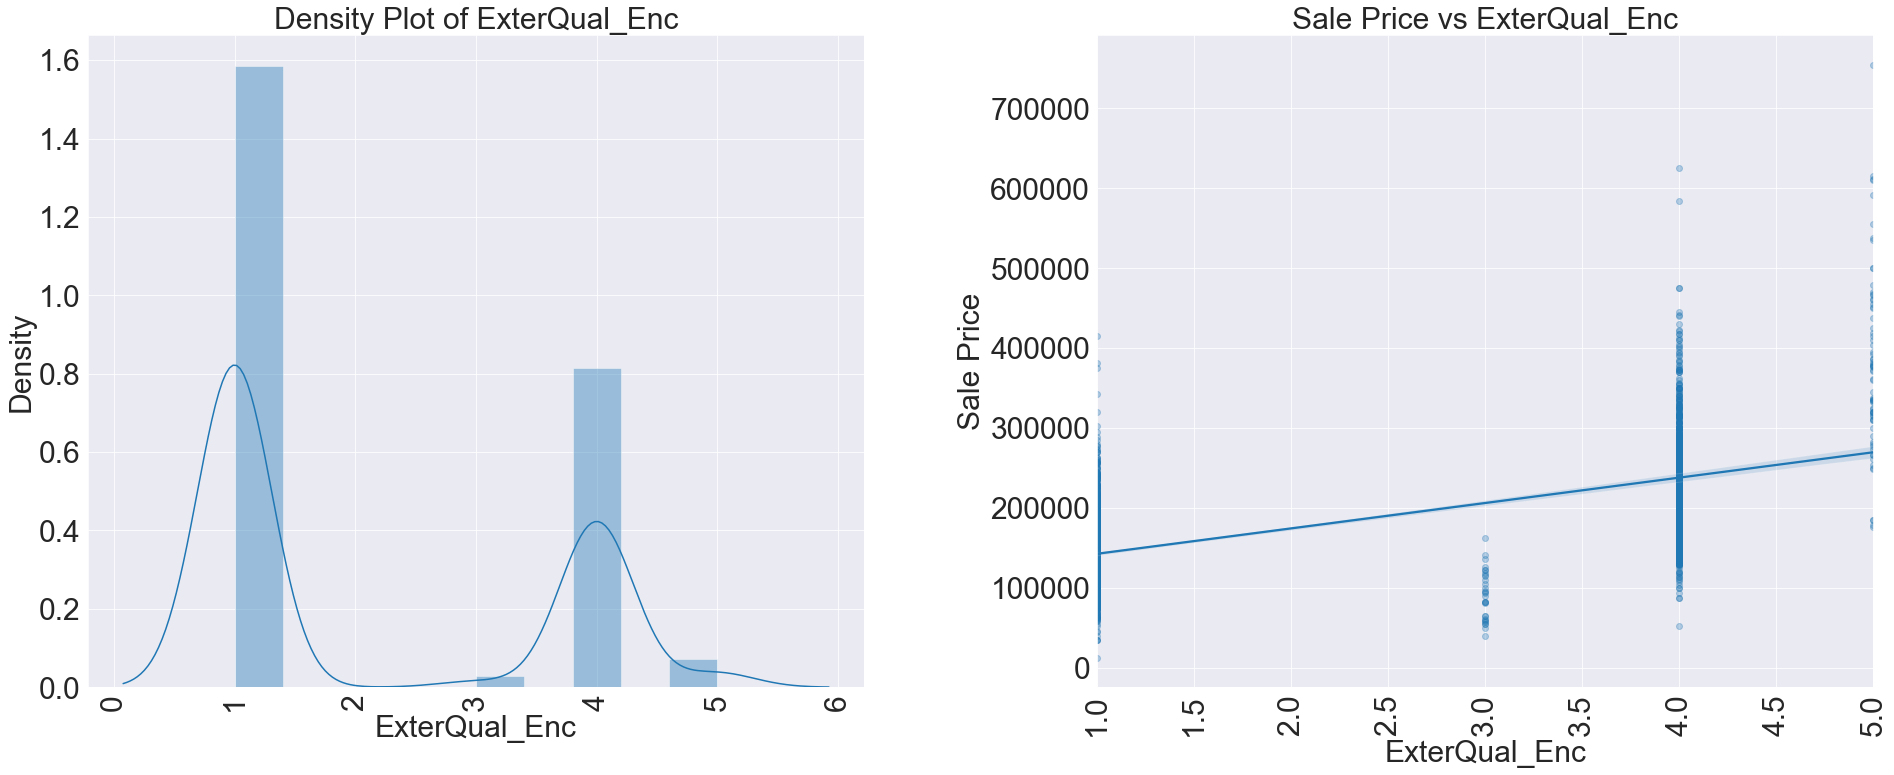

In [373]:
for feature in top_corr_features.index:
    if feature == 'SalePrice':
        continue
    feature_plot(housePrice, feature)

## OneHot Encoding for nominals

In [374]:
hp_num2 = housePrice.select_dtypes(include = [np.number])
hp_cat2 = housePrice.select_dtypes(exclude = [np.number])
print("numberfied:", hp_num2.shape[1])
print("to OneHot:", hp_cat2.shape[1])

numberfied: 53
to OneHot: 24


In [375]:
housePrice = pd.get_dummies(housePrice, columns=hp_cat_nom, drop_first=True)

In [376]:
housePrice.to_csv('HousePrice_Encoded.csv')

# Transformations

## Normalizing Skewed Features for Regression Models

In [377]:
# copy of non-transformed df
housePrice_noTrans = housePrice.copy()

**highly skewed features**

In [378]:
continuous = pd.DataFrame(hp_num.columns, columns=['Features'])
continuous["Skew"] = scipy.stats.skew(hp_num)
continuous["AbsSkew"] = np.abs(continuous["Skew"])
skewedFeatures = continuous.loc[continuous["AbsSkew"] > 1].sort_values("AbsSkew",ascending=False)
skewed_data = hp_num[skewedFeatures['Features']]

array([[<AxesSubplot:title={'center':'MiscVal'}>,
        <AxesSubplot:title={'center':'PoolArea'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'LotArea'}>],
       [<AxesSubplot:title={'center':'3SsnPorch'}>,
        <AxesSubplot:title={'center':'KitchenAbvGr'}>,
        <AxesSubplot:title={'center':'GarageYrBlt'}>,
        <AxesSubplot:title={'center':'EnclosedPorch'}>],
       [<AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'ScreenPorch'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>,
        <AxesSubplot:title={'center':'BsmtHalfBath'}>],
       [<AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'OpenPorchSF'}>,
        <AxesSubplot:title={'center':'WoodDeckSF'}>,
        <AxesSubplot:title={'center':'SalePrice'}>],
       [<AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>, <AxesSubplot:>,
        <AxesSubplot:>]]

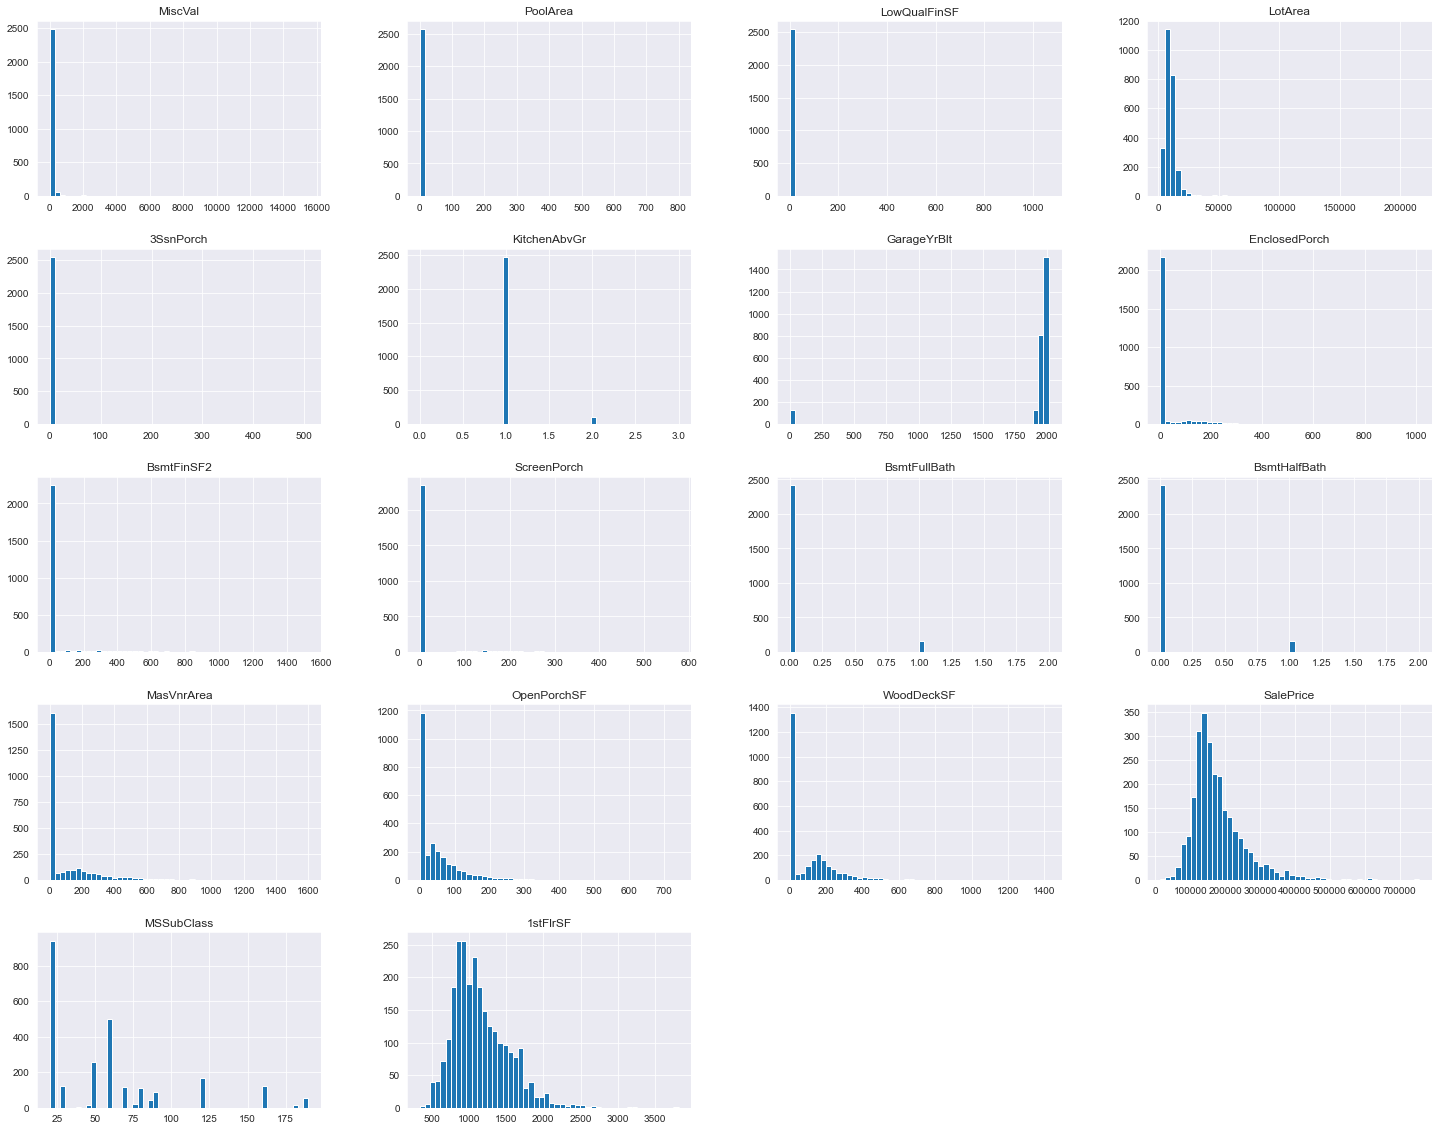

In [379]:
skewed_data.hist(bins = 50, figsize = (25,20))  ## visualization shows us most skews are zero-inflated

array([[<AxesSubplot:title={'center':'MiscVal'}>,
        <AxesSubplot:title={'center':'PoolArea'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'LotArea'}>],
       [<AxesSubplot:title={'center':'3SsnPorch'}>,
        <AxesSubplot:title={'center':'KitchenAbvGr'}>,
        <AxesSubplot:title={'center':'GarageYrBlt'}>,
        <AxesSubplot:title={'center':'EnclosedPorch'}>],
       [<AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'ScreenPorch'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>,
        <AxesSubplot:title={'center':'BsmtHalfBath'}>],
       [<AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'OpenPorchSF'}>,
        <AxesSubplot:title={'center':'WoodDeckSF'}>,
        <AxesSubplot:title={'center':'SalePrice'}>],
       [<AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>, <AxesSubplot:>,
        <AxesSubplot:>]]

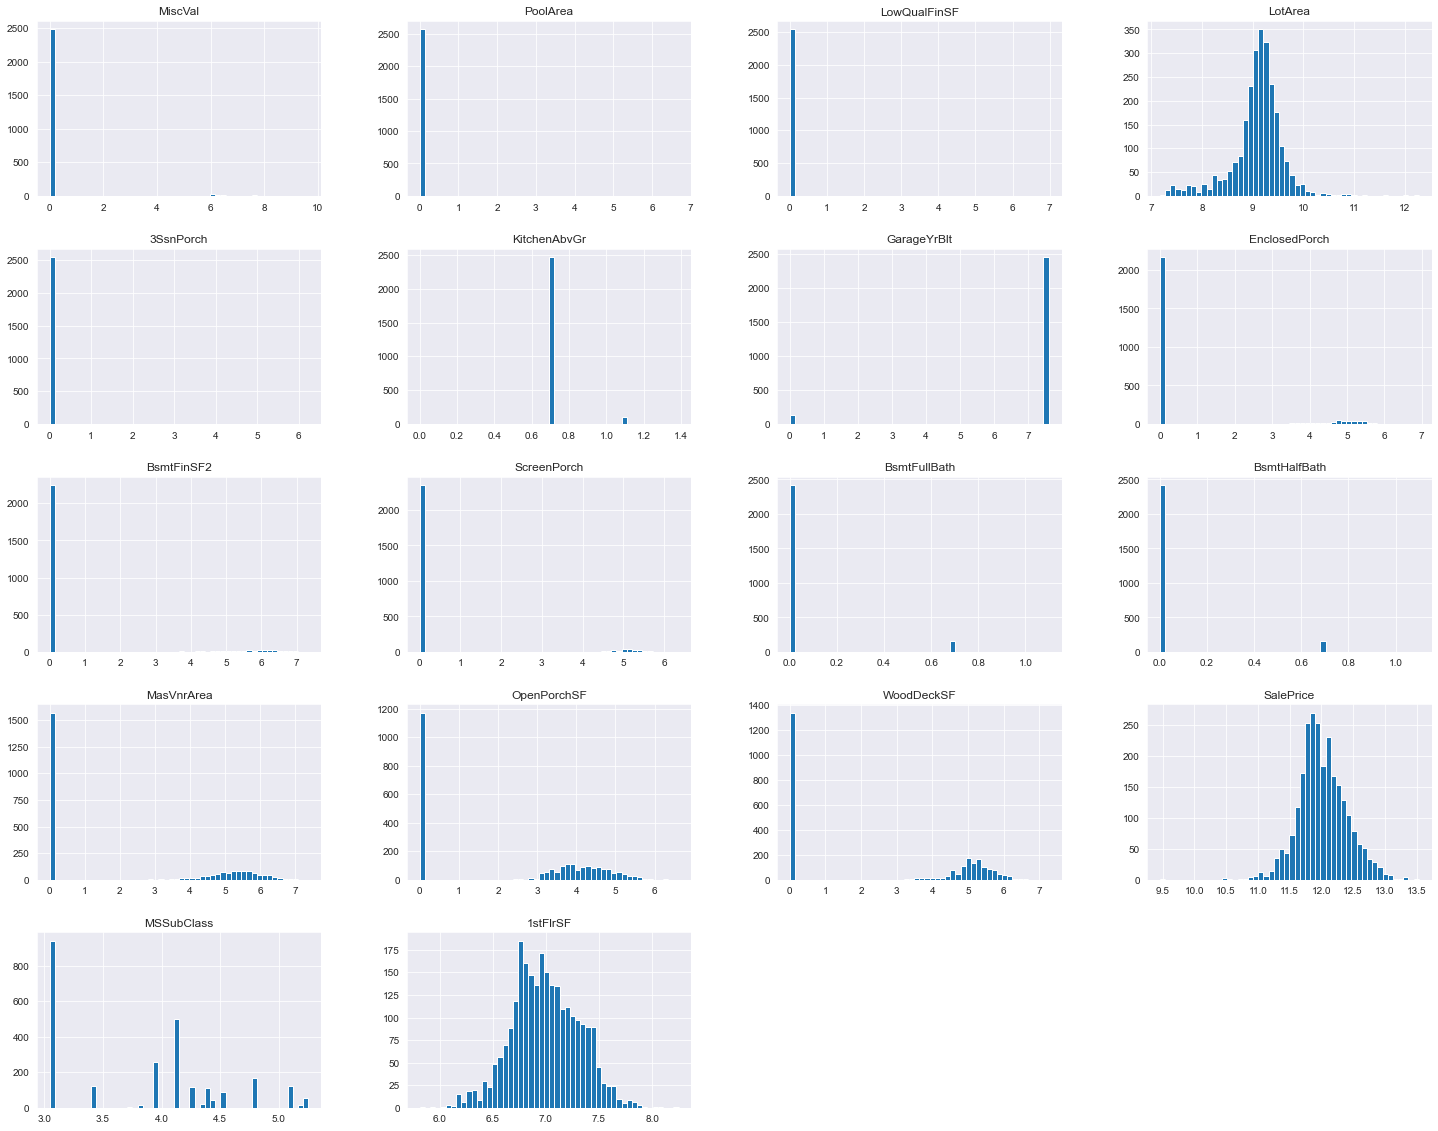

In [380]:
for feature in skewed_data.columns:
    log_skewed = boxcox1p(skewed_data, 0)
log_skewed.hist(bins = 50, figsize = (25,20))

**moderately skewed features**

array([[<AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>],
       [<AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'Fireplaces'}>,
        <AxesSubplot:title={'center':'HalfBath'}>],
       [<AxesSubplot:title={'center':'TotRmsAbvGrd'}>,
        <AxesSubplot:title={'center':'OverallCond'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>],
       [<AxesSubplot:title={'center':'TotalBsmtSF'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

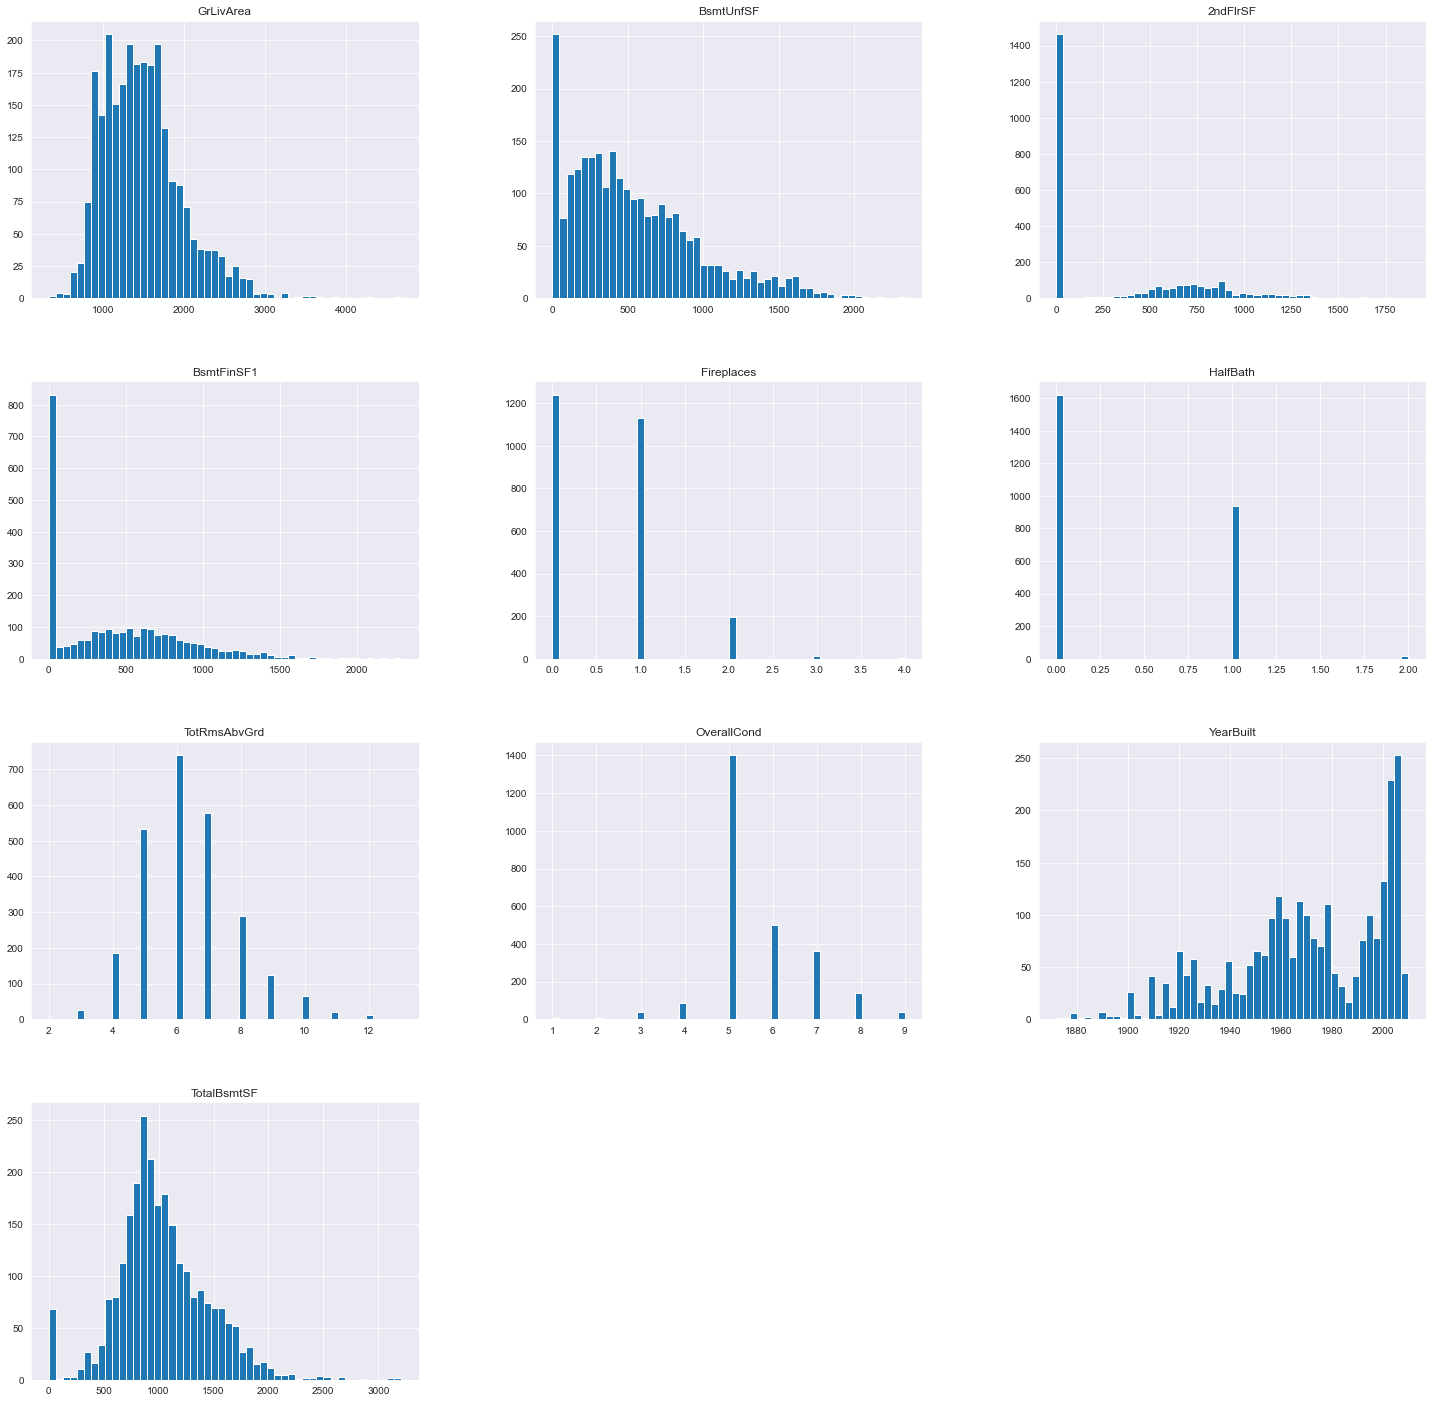

In [381]:
modSkewedFeatures = continuous.loc[continuous["AbsSkew"] > .5]
modSkewedFeatures = modSkewedFeatures.loc[modSkewedFeatures["AbsSkew"] < 1].sort_values("AbsSkew",ascending=False)
modSkewed_data = hp_num[modSkewedFeatures['Features']]

modSkewed_data.hist(bins=50, figsize=(25,25))

array([[<AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>],
       [<AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'Fireplaces'}>,
        <AxesSubplot:title={'center':'HalfBath'}>],
       [<AxesSubplot:title={'center':'TotRmsAbvGrd'}>,
        <AxesSubplot:title={'center':'OverallCond'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>],
       [<AxesSubplot:title={'center':'TotalBsmtSF'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

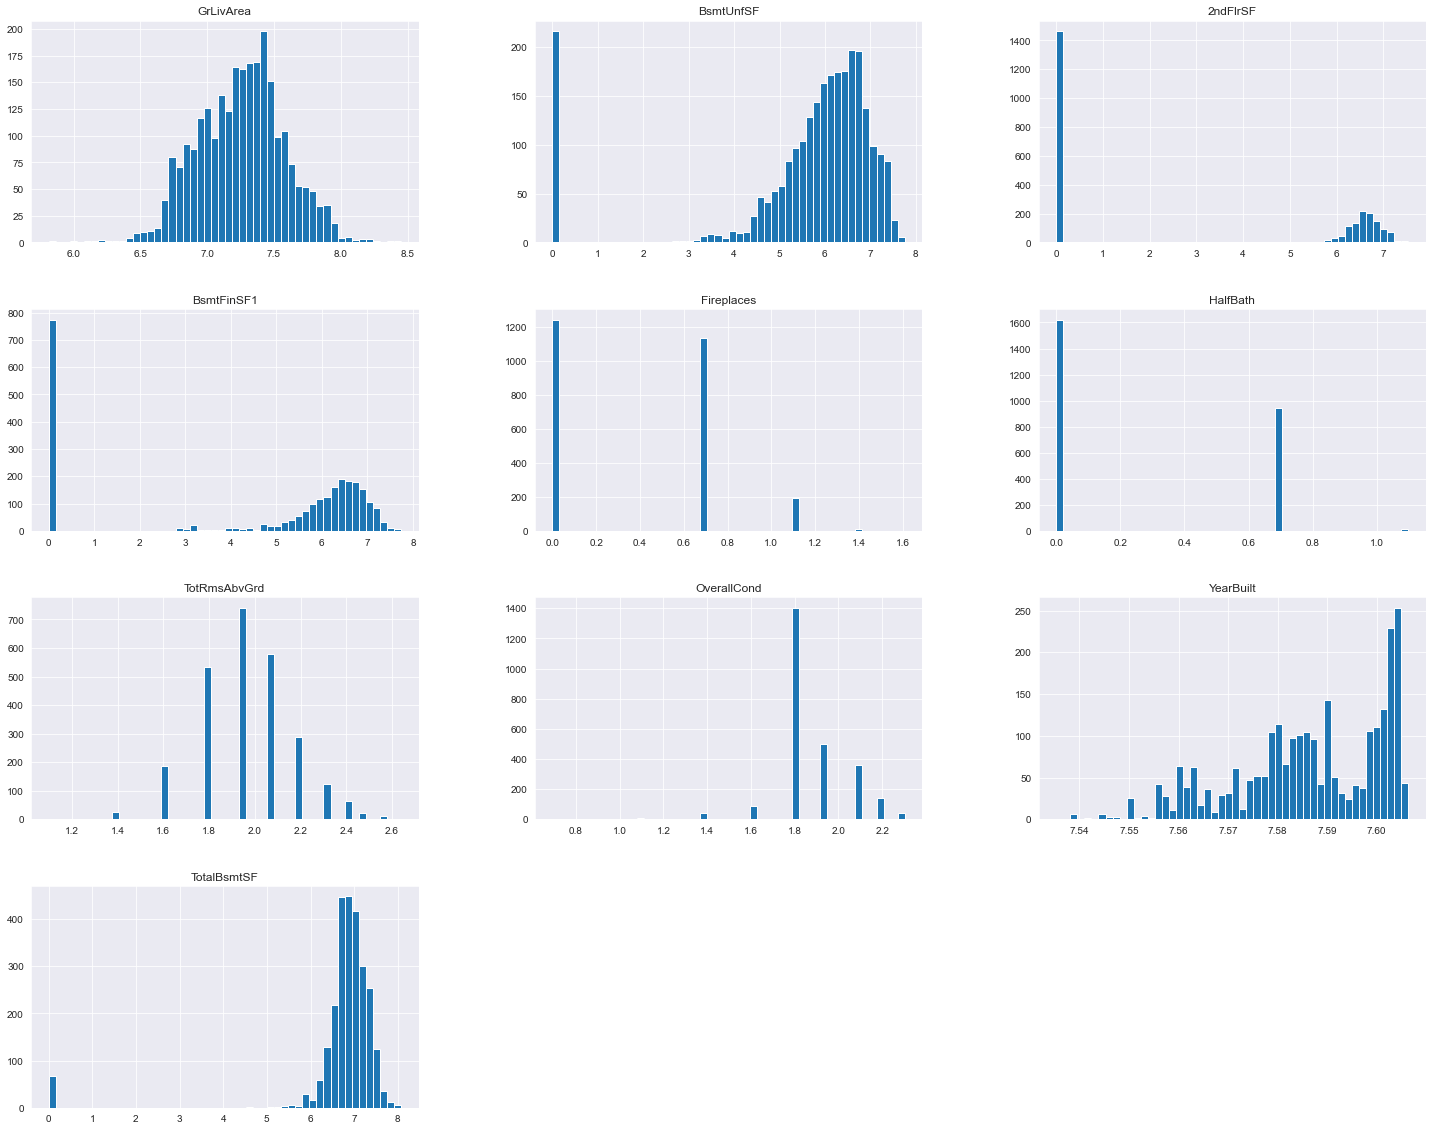

In [382]:
for feature in modSkewed_data.columns:
    log_modSkewed = boxcox1p(modSkewed_data, 0)
log_modSkewed.hist(bins=50, figsize=(25,20))

In [383]:
def skew(df):
    for feature in df.columns:
        return df.skew()

In [384]:
# impact of log on extreme skewness 
pd.DataFrame(zip(skewed_data, skew(skewed_data),skew(log_skewed)), columns=['Features','Skew','LogSkew'])

,Features,Skew,LogSkew
0,MiscVal,21.289244,5.070769
1,PoolArea,19.896697,17.022505
2,LowQualFinSF,13.260484,8.887806
3,LotArea,13.073543,-0.504301
4,3SsnPorch,11.830265,9.199796
5,KitchenAbvGr,4.531245,3.852175
6,GarageYrBlt,-4.110661,-4.131512
7,EnclosedPorch,4.041800,1.943826
8,BsmtFinSF2,3.992173,2.324094
9,ScreenPorch,3.990628,2.949545


In [385]:
# impact of log on moderate skewness 
pd.DataFrame(zip(modSkewed_data, skew(modSkewed_data),skew(log_modSkewed)), columns=['Features','Skew','LogSkew'])

,Features,Skew,LogSkew
0,GrLivArea,0.980065,-0.057542
1,BsmtUnfSF,0.962843,-2.141409
2,2ndFlrSF,0.821364,0.288093
3,BsmtFinSF1,0.803047,-0.710171
4,Fireplaces,0.735199,0.223143
5,HalfBath,0.670014,0.574173
6,TotRmsAbvGrd,0.669102,-0.020557
7,OverallCond,0.624716,-0.494076
8,YearBuilt,-0.598177,-0.625740
9,TotalBsmtSF,0.515246,-5.033949


In [386]:
log_modSkewed

,GrLivArea,BsmtUnfSF,2ndFlrSF,BsmtFinSF1,Fireplaces,HalfBath,TotRmsAbvGrd,OverallCond,YearBuilt,TotalBsmtSF
0,6.753438,6.428105,0.000000,5.476464,0.693147,0.000000,1.609438,1.945910,7.570443,6.753438
1,6.956545,4.653960,0.000000,6.315358,0.000000,0.000000,1.791759,1.791759,7.593374,6.956545
2,6.909753,4.615121,0.000000,6.603944,0.000000,0.000000,1.791759,2.302585,7.565793,6.731018
3,6.946976,6.006353,5.777652,0.000000,0.000000,0.000000,1.945910,2.197225,7.550135,6.006353
4,7.418181,5.123964,6.752270,6.467699,0.000000,0.693147,1.945910,1.945910,7.601902,6.698268
...,...,...,...,...,...,...,...,...,...,...
2575,6.859615,6.859615,0.000000,0.000000,0.693147,0.000000,1.609438,1.945910,7.558517,6.859615
2576,7.458186,0.000000,0.000000,0.000000,0.693147,0.000000,2.197225,1.791759,7.578657,0.000000
2577,7.602401,6.576470,6.909753,5.652489,0.000000,0.000000,2.197225,1.945910,7.575585,6.909753
2578,7.519150,4.976734,6.754604,6.735780,0.693147,0.693147,2.079442,1.791759,7.601402,6.893656


In [402]:
# inserting log of skewed to dataframe
housePrice[log_skewed.columns] = log_skewed
housePrice[log_modSkewed.columns] = log_modSkewed
housePrice

,GrLivArea,SalePrice,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,cos_MoSold,sin_MoSold
0,6.753438,11.744045,3.433987,8.973478,-0.033733,1.945910,7.570443,-1.647539,0.000000,5.476464,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,0.548396,1.472259
1,6.956545,11.845827,4.795791,8.351375,-0.765088,1.791759,7.593374,0.012109,5.010635,6.315358,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,1.306642,1.268766
2,6.909753,11.735277,3.433987,8.709630,-0.765088,2.302585,7.565793,1.134812,0.000000,6.603944,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,1.861716,-0.806081
3,6.946976,11.643962,4.262680,9.005405,-1.496443,2.197225,7.550135,0.939559,0.000000,0.000000,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,-0.764924,0.712813
4,7.418181,12.332710,4.110874,9.036106,1.428977,1.945910,7.601902,0.841933,0.000000,6.467699,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,1.861716,-0.806081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,6.859615,11.703554,3.433987,9.088738,-0.033733,1.945910,7.558517,-1.647539,0.000000,0.000000,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,-0.764924,0.712813
2576,7.458186,11.846544,3.044522,9.523763,-2.227798,1.791759,7.578657,-1.403473,0.000000,0.000000,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,-0.968095,-0.046634
2577,7.602401,11.884496,4.510860,8.743691,-0.765088,1.945910,7.575585,-1.647539,0.000000,5.652489,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,-0.209850,-1.362034
2578,7.519150,12.289959,4.110874,9.085570,0.697622,1.791759,7.601402,0.793120,4.976734,6.735780,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,-0.764924,-0.806081


### Transform Cyclical Features with Cosine and Sine Wave
- Months are cyclical, due to seasonal changes
- A negative cosine wave (y=-cos(x)) can represent this pattern, where month 1 and month 12 are similar and start from the same point high values mean hot and low values mean cold
- $cos(x)$ and $sin(x)$

In [388]:
import math 
# normalize for these calculations 
housePrice["MoSold_norm"] = 2 * math.pi * housePrice["MoSold"]  / housePrice["MoSold"].max()
# assign both sine and cosine values to make sure each value has a unique 
# and still cyclical value (march and october aren't percieved as the same item)
housePrice["cos_MoSold"] = np.cos( housePrice["MoSold_norm"])
housePrice["sin_MoSold"] = np.sin( housePrice["MoSold_norm"])
housePrice_cyc = housePrice.drop(columns=['MoSold_norm','MoSold'])
# housePrice["sincos_MoSold"] = np.sin( housePrice["cos_MoSold"])
# housePrice.MoSold = np.cos(0.5*housePrice.MoSold)

## Standardization / Standard Scaling

In [393]:
standard = StandardScaler()
standard.fit(housePrice)
housePrice = pd.DataFrame(standard.transform(housePrice), index = housePrice.index, columns = housePrice.columns)
housePrice

,GrLivArea,SalePrice,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,cos_MoSold,sin_MoSold
0,-1.547036,-0.695761,-0.570288,-0.217538,-0.033733,0.411905,-1.049749,-1.647539,-0.786282,0.387708,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,0.548396,1.472259
1,-0.917751,-0.432930,1.392400,-1.420232,-0.765088,-0.490852,0.464386,0.012109,1.134535,0.673899,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,1.306642,1.268766
2,-1.062726,-0.718403,-0.570288,-0.727628,-0.765088,2.500710,-1.356788,1.134812,-0.786282,0.772352,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,1.861716,-0.806081
3,-0.947400,-0.954203,0.624059,-0.155815,-1.496443,1.883684,-2.390685,0.939559,-0.786282,-1.480607,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,-0.764924,0.712813
4,0.512527,0.824344,0.405270,-0.096461,1.428977,0.411905,1.027476,0.841933,-0.786282,0.725871,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,1.861716,-0.806081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,-1.218069,-0.800320,-0.570288,0.005290,-0.033733,0.411905,-1.837260,-1.647539,-0.786282,-1.480607,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,-0.764924,0.712813
2576,0.636475,-0.431079,-1.131600,0.846312,-2.227798,-0.490852,-0.507404,-1.403473,-0.786282,-1.480607,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,-0.968095,-0.046634
2577,1.083295,-0.333075,0.981745,-0.661778,-0.765088,0.411905,-0.710262,-1.647539,-0.786282,0.447759,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,-0.209850,-1.362034
2578,0.825358,0.713948,0.405270,-0.000833,0.697622,-0.490852,0.994486,0.793120,1.121539,0.817328,...,-0.039406,-0.019691,0.280349,-0.027853,-0.039406,-0.081442,0.262232,-0.18118,-0.764924,-0.806081


# Modeling

In [427]:
target = housePrice['SalePrice'] 
features = housePrice.drop(columns='SalePrice')

### Multiple Linear Regression

In [435]:
ols = LinearRegression() 
ols.fit(features, target)

LinearRegression()

In [429]:
# Logistic not sensical for this continuous variable
# pred = lm.predict(features)
# (target == pred).mean()

In [446]:
# first glance 
print('R^2', ols.score(features, target))
print('RSS', np.sum((ols.predict(features) - target) ** 2))
print('beta0:' + str(np.round(ols.intercept_, 2)))

R^2 0.9383482074539757
RSS 23.853633268079015
beta0:-24.05


### Feature Selection with Variance Inflation Factor (VIF)

#### Train Test Split

In [450]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.5, random_state=0)

In [451]:
ols = LinearRegression()
ols.fit(X_train, y_train)
print('Rsq train', ols.score(X_train, y_train))
print('Rsq test', ols.score(X_test, y_test))

Rsq train 0.9480750054666632
Rsq test -3.8614019319269336e+21


#### Stratified K-fold Split

In [ ]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for training_idx, validation_idx in skfold.split(X_train, y_train):
    